In [1264]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import sklearn


# Определение уязвимых групп населения

## Цели и задачи работы

1. кластеризовать регионы России и определить, какие из них наиболее остро нуждаются в помощи малообеспеченным/неблагополучным слоям населения;

2. описать группы населения, сталкивающиеся с бедностью;

3. определить: 
- влияет ли число детей, пенсионеров и других социально уязвимых групп на уровень бедности в регионе;
- связаны ли уровень бедности/социального неблагополучия с производством и потреблением в регионе;
- какие ещё зависимости можно наблюдать относительно социально незащищённых слоёв населения.

## 1. Сбор данных

Так как в разных таблицах названия регионов даны по разному, предварительно необходимо написть функции для предобработки столбца с пеерчислением регионов.

In [1265]:
# Функция удаляет лтшние пробелы, знаки переноса строки и приводит назвние к нижнему регистру.
# Так же функция заменяет значения не являющиеря регионами на np.nan
def index_nomalizer(ind: list) -> list:
    accep_list = ['край', 'обл', 'респуб', 'москв', 'автон', 'петерб', 'севаст']
    arch_flag = 0
    tum_flag = 0
    mosc_flag = 0
    mosc_obl_flag = 0
    for n in range(len(ind)):
        flag = 0
        ind[n] = ind[n].lower()
        
        for elem in accep_list:
            if elem in ind[n]:
                flag = 1
        
        if ('арханг' in ind[n]):
            arch_flag += 1 
            if arch_flag > 1:
                flag = 0
            
        if ('тюмен' in ind[n]):
            tum_flag += 1
            if tum_flag > 1:
                flag = 0
                
        if ('москва' in ind[n]):
            mosc_flag += 1
            if mosc_flag > 1:
                flag = 0
                
        if ('московс' in ind[n]):
            mosc_obl_flag += 1
            if mosc_obl_flag > 1:
                flag = 0

        ind[n] = ind[n].replace('\n', ' ').replace('.', '')
        
        if ('(' in ind[n]) and (')' in ind[n]):
            elem = re.search(r'\((.+)\)', ind[n])
            ind[n] = ind[n][:elem.start()] + ind[n][elem.end():]  
            
        ind[n] = ' '.join(ind[n].split())
          
        if not flag:
            ind[n] = np.nan
            
    # for n in range(len(ind)):
    #     if arch_flag > 1 and ind[n] is not np.nan:
    #         if ('арханг' in ind[n]) and not (('без' in ind[n]) or ('кроме' in ind[n])):
    #             ind[n] = np.nan 
              
    #     if tum_flag > 1 and ind[n] is not np.nan:
    #         if ('тюмен' in ind[n]) and not (('без' in ind[n]) or ('кроме' in ind[n])):
    #             ind[n] = np.nan
                
    return ind

In [1266]:
# Функция удаляет лишние символы в наименовании регионов
def index_standartizer(ind: list) -> list:
    for n in range(len(ind)):     
        if ind[n] is np.nan:
            pass
        elif 'край' in ind[n]:
            elem = re.search('край', ind[n])
            ind[n] = ind[n][:elem.end()]
        elif 'обл'  in ind[n]:
            elem = re.search('обл', ind[n])
            ind[n] = ind[n][:elem.end()]
        elif 'округ'  in ind[n] and 'авт'in ind[n]:
            elem = re.search('округ', ind[n])
            ind[n] = ind[n][:elem.end()]
        elif 'респуб'  in ind[n]:
            splitted = ind[n].split(' ')
            ind[n] = splitted[0] + ' ' + splitted[1]
        elif 'москва'  in ind[n]:
            elem = re.search('москва', ind[n])
            ind[n] = ind[n][elem.start():elem.end()]
        elif 'севастополь'  in ind[n]:
            elem = re.search('севастополь', ind[n])
            ind[n] = ind[n][elem.start():elem.end()]
        elif 'санкт-петербург'  in ind[n]:
            elem = re.search('санкт-петербург', ind[n])
            ind[n] = ind[n][elem.start():elem.end()]
    return ind

Исходя из визуального анализа предложенных для анализа таблиц, можно сделать вывод, что наиболее полные данные у нас есть только за 2020 год. Во избежание изменений проблем с изменением учета статистических данных имеет смысл рассматривать данные за один и тот же год. Поэтому предлагаю сразу создавать датасет по даннным на 2020 год.

In [1267]:
year = 2020

data_list = []

#б/н Среднедушевые денежные доходы (в месяц), руб.
per_capita_cash_income = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name='per_capita_cash_income')
per_capita_cash_income = per_capita_cash_income[['region', year]]
#0 Реальные денежные доходы, в процентах к предыдущему году
per_capita_cash_income_real_incomes = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name='real_incomes')
per_capita_cash_income_real_incomes = per_capita_cash_income_real_incomes[['region', year]].rename(columns={year: 'per_capita_cash_income_real_incomes'})
data_list.append(per_capita_cash_income_real_incomes)
#1 Среднемесячная номинальная начисленная заработная плата, руб
formal_wage_paid = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name='formal_wage_paid')
formal_wage_paid = formal_wage_paid[['region', year]].rename(columns={year: 'formal_wage_paid'})
data_list.append(formal_wage_paid)
#2 Реальная начисленная заработная плата, в процентах к предыдущему году
formal_wage_paid_real_pay = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name='real_pay')
formal_wage_paid_real_pay = formal_wage_paid_real_pay[['region', year]].rename(columns={year: 'formal_wage_paid_real_pay'})
data_list.append(formal_wage_paid_real_pay)

#3 Число умерших на первом году жизни детей за год (человек, значение показателя за год) сельское население
child_mortality_rural = pd.read_excel('data/child_mortality_rural_1990_2021.xls', sheet_name='Данные', header=2)
child_mortality_rural.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
child_mortality_rural.drop(['Unnamed: 1', 'Unnamed: 2'], inplace=True, axis=1)
child_mortality_rural = child_mortality_rural[['region', f'{year}']].rename(columns={f'{year}': 'child_mortality_rural'})
data_list.append(child_mortality_rural)


#4 Число умерших на первом году жизни детей за год (человек, значение показателя за год) городское население
child_mortality_urban = pd.read_excel('data/child_mortality_rural_1990_2021.xls', sheet_name='Данные', header=2)
child_mortality_urban.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
child_mortality_urban.drop(['Unnamed: 1', 'Unnamed: 2'], inplace=True, axis=1)
child_mortality_urban = child_mortality_urban[['region', f'{year}']].rename(columns={f'{year}': 'child_mortality_urban'})
data_list.append(child_mortality_urban)

#5 число людей с инвалидностью по регионам, по месяцам, по возрастным группам.
disabled_total_by_age =  pd.read_csv('data/disabled_total_by_age_2017_2022.csv')
disabled_total_by_age = disabled_total_by_age[(disabled_total_by_age['date'] >= f'{year}-01-01') & (\
    disabled_total_by_age['date'] <= f'{year}-12-01')].drop('date', axis=1).groupby('region').mean()
disabled_total_by_age['region'] = disabled_total_by_age.index
disabled_total_by_age.reset_index(drop=True, inplace=True)
data_list.append(disabled_total_by_age)

# drug_alco.xlsx исключаем за отсутствием статистики на 2020 год.

#6 валовой региональный продукт на душу населения, в рублях.
gross_regional_product = pd.read_excel('data/gross_regional_product_1996_2020.xls', sheet_name='Данные', header=2)
gross_regional_product.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
gross_regional_product = gross_regional_product[['region', f'{year}']].rename(columns={f'{year}': 'gross_regional_product'})
data_list.append(gross_regional_product)

#7 Характеристика жилищных условий домохозяйств, % от всех домохозяйств
housing_cond = pd.read_excel('data/housing_2020.xlsx', sheet_name='housing_cond')
housing_cond = housing_cond.drop('Число домохозяйств, проживающих во всех типах жилых помещений', axis=1)
housing_cond.rename(columns={'Регион': 'region'}, inplace=True)
# housing_cond = housing_cond.dropna(subset='region', axis=0)
data_list.append(housing_cond)
#8 Оценка домохозяйствами состояния занимаемого ими жилого помещения, % от всех домохозяйств
housing_intent = pd.read_excel('data/housing_2020.xlsx', sheet_name='housing_intent')
housing_intent = housing_intent.drop('Все домохозяйства', axis=1)
housing_intent = housing_intent.replace('...', np.nan)
housing_intent = housing_intent.replace('…*', np.nan)
housing_intent.rename(columns={'Регион': 'region'}, inplace=True)
# housing_intent = housing_cond.dropna(subset='region', axis=0)
data_list.append(housing_intent)

# morbidity_2005_2020_age_disease.xls исключаем за отсутствием статистики на 2020 год.

#9 среднее число новорожденных в месяц.
newborn =  pd.read_csv('data/newborn_2006_2022_monthly.csv', sep=';', decimal=',')
cols = []
for elem in newborn.columns:
    if f'{year}' in elem:
        cols.append(elem)
cols

newborn = newborn[['Region', *cols]]
newborn['middle_newborn'] = newborn[[*cols]].mean(axis=1)
newborn.drop(cols, axis=1, inplace=True)
newborn.rename(columns={'Region': 'region'}, inplace=True)
data_list.append(newborn)

#10 численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 гг.
population = pd.read_excel('data/population.xlsx', sheet_name='Отчет')
population.rename(columns={'Unnamed: 0': 'region', f'23110000100030200002 Численность постоянного населения на 1 января.{str(year)[-2:]}': year}, inplace=True)
population.drop(['Unnamed: 1'], inplace=True, axis=1)
population.drop(index=0, inplace=True, axis=0)
population['region'] = population['region'].shift(1)
population[year] = population[year].astype(np.float64)
population = population[['region', year]].rename(columns={year: 'population'})
#11 population = population.dropna(subset='region', axis=0)
data_list.append(population)

#12 процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам.
poverty_percent_by_regions =  pd.read_csv('data/poverty_percent_by_regions_1992_2020.csv')
poverty_percent_by_regions = poverty_percent_by_regions[poverty_percent_by_regions['year'] == year]
poverty_percent_by_regions.drop('year', axis=1, inplace=True)
data_list.append(poverty_percent_by_regions)


#13 распределение малоимущего населения по социально-демографическим группам (дети, трудящиеся, пенсионеры) за 2017–2020 гг., по регионам.
poverty_socdem = pd.read_excel(f'data/poverty_socdem_{year}.xls', sheet_name='Данные', header=2)
poverty_socdem.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
poverty_socdem.drop('Все население', axis=1, inplace=True)
data_list.append(poverty_socdem)

#14 объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам
# деятельности за 2005–2016 гг., 2017–2020 гг. (в тысячах рублей, значение показателя за год, полный круг).
regional_production =  pd.read_csv('data/regional_production_2017_2020.csv')
regional_production = regional_production[['region', 'production_field', f'{year}']]
regional_production = regional_production.pivot(index='region', columns='production_field', values=f'{year}')
regional_production['region'] = regional_production.index
regional_production.reset_index(drop=True, inplace=True)
data_list.append(regional_production)

#15 оборот розничной торговли на душу населения, в рублях.
retail_turnover_per_capita = pd.read_excel(f'data/retail_turnover_per_capita_2000_2021.xls', sheet_name='Данные', header=2)
retail_turnover_per_capita.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
retail_turnover_per_capita.drop('Unnamed: 1', axis=1, inplace=True)
retail_turnover_per_capita.drop(index=0, inplace=True, axis=0)
retail_turnover_per_capita[f'{year}'] = retail_turnover_per_capita[f'{year}'].astype(np.float64)
retail_turnover_per_capita = retail_turnover_per_capita[['region', f'{year}']].rename(columns={f'{year}': 'retail_turnover_per_capita'})
# retail_turnover_per_capita = retail_turnover_per_capita.dropna(subset='region', axis=0)
data_list.append(retail_turnover_per_capita)

#16 расходы на социальную политику от общих расходов бюджета региона, % в год
welfare_expense_share = pd.read_excel('data/welfare_expense_share_2015_2020.xlsx', sheet_name='data')
welfare_expense_share = welfare_expense_share[['region', year]].rename(columns={year: 'welfare_expense_share'})
data_list.append(welfare_expense_share)

C:\Users\zhigu\AppData\Local\Temp\ipykernel_33908\846592874.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  housing_intent = housing_intent.replace('...', np.nan)
C:\Users\zhigu\AppData\Local\Temp\ipykernel_33908\846592874.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  housing_intent = housing_intent.replace('…*', np.nan)


создаем датасет за 2020 год.

In [1268]:
region = index_nomalizer(list(per_capita_cash_income['region']))
region = index_standartizer(region)

per_capita_cash_income['region'] = region


per_capita_cash_income.dropna(axis=0, inplace=True)
per_capita_cash_income.reset_index(drop=True, inplace=True)

data = per_capita_cash_income[['region', year]].rename(columns={year: 'per_capita_cash_income'})
data = data.set_index('region')

In [1269]:
for n in range(len(data_list)):
    data_list[n] = data_list[n].dropna(subset='region', axis=0)
    region = index_nomalizer(list(data_list[n]['region']))
    region = index_standartizer(region)
    data_list[n]['region'] = region
    data_list[n] = data_list[n].dropna(subset='region', axis=0)
    data_list[n] = data_list[n].set_index('region')
    # data = data.merge(right=data_list[n], how='left', right_index =True, left_index=True)
    # data = data.groupby('region').mean()
    data = data.join(data_list[n], how='left', on='region', sort=True, rsuffix='_other')

C:\Users\zhigu\AppData\Local\Temp\ipykernel_33908\2610834017.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_list[n]['region'] = region
C:\Users\zhigu\AppData\Local\Temp\ipykernel_33908\2610834017.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_list[n]['region'] = region


создаем датасет по претупности за 2020 год.

In [1270]:
cols = ['region', 'несовершеннолетними или при их соучастии', 'ранее совершавшими преступления', 'в том числе ранее судимыми', 'группой лиц', \
    'группой лиц по предварительному сговору', 'организованной группой', 'преступным сообществом (преступной организацией)', \
        'в состоянии опьянения алкогольного', 'в состоянии опьянения наркотического', 'в состоянии опьянения токсического' ]

crime_list = []

# 0 Сведения о преступлениях, совершенных отдельными категориями лиц (по расследованным преступлениям) Всего
crime_total = pd.read_excel(f'data/crimes/4-EGS_Razdel_4_122020.xls', sheet_name='Строка 1', header=9)
crime_total.drop(columns=['Unnamed: 0'], inplace=True)
crime_total.drop(index=0, inplace=True)
crime_total.columns = cols
crime_list.append(crime_total)
# 1 Сведения о преступлениях, совершенных отдельными категориями лиц (по расследованным преступлениям) особо тяжких
crime_especially_serious = pd.read_excel(f'data/crimes/4-EGS_Razdel_4_122020.xls', sheet_name='Строка 2', header=9)
crime_especially_serious.drop(columns=['Unnamed: 0'], inplace=True)
crime_especially_serious.drop(index=0, inplace=True)
crime_especially_serious.columns = cols
crime_list.append(crime_especially_serious)
# 2 Сведения о преступлениях, совершенных отдельными категориями лиц (по расследованным преступлениям) тяжких
crime_serious = pd.read_excel(f'data/crimes/4-EGS_Razdel_4_122020.xls', sheet_name='Строка 3', header=9)
crime_serious.drop(columns=['Unnamed: 0'], inplace=True)
crime_serious.drop(index=0, inplace=True)
crime_serious.columns = cols
crime_list.append(crime_serious)
# 3 Сведения о преступлениях, совершенных отдельными категориями лиц (по расследованным преступлениям) средней тяжести
medium_gravity_crime = pd.read_excel(f'data/crimes/4-EGS_Razdel_4_122020.xls', sheet_name='Строка 4', header=9)
medium_gravity_crime.drop(columns=['Unnamed: 0'], inplace=True)
medium_gravity_crime.drop(index=0, inplace=True)
medium_gravity_crime.columns = cols
crime_list.append(medium_gravity_crime)
# 4 Сведения о преступлениях, совершенных отдельными категориями лиц (по расследованным преступлениям) небольшой тяжести
minor_crime = pd.read_excel(f'data/crimes/4-EGS_Razdel_4_122020.xls', sheet_name='Строка 5', header=9)
minor_crime.drop(columns=['Unnamed: 0'], inplace=True)
minor_crime.drop(index=0, inplace=True)
minor_crime.columns = cols
crime_list.append(minor_crime)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [1271]:
for n in range(len(crime_list)):
    crime_list[n] = crime_list[n].dropna(subset='region', axis=0)
    region = index_nomalizer(list(crime_list[n]['region']))
    region = index_standartizer(region)
    crime_list[n]['region'] = region
    crime_list[n] = crime_list[n].dropna(subset='region', axis=0)
    for col in crime_list[n].columns[1:]:
        if crime_list[n][col].dtype is np.dtype('O'):
            crime_list[n][col] = crime_list[n][col].astype('float64')

C:\Users\zhigu\AppData\Local\Temp\ipykernel_33908\1164692419.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_list[n]['region'] = region
C:\Users\zhigu\AppData\Local\Temp\ipykernel_33908\1164692419.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_list[n]['region'] = region
C:\Users\zhigu\AppData\Local\Temp\ipykernel_33908\1164692419.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

## 2. Предобработка и очистка данных

In [1272]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, алтайский край to ярославская обл
Columns: 173 entries, per_capita_cash_income to welfare_expense_share
dtypes: float64(173)
memory usage: 115.5+ KB


Так как известно, что все данные числовые, проверим их на отсутствие пропусков.

In [1273]:
for n in range(len(data_list)):
    if data_list[n].isna().sum().sum() !=0:
        print(f'датасет № {n} всего пропусков: {data_list[n].isna().sum().sum()}\n')
        display(data_list[n].info())

датасет № 3 всего пропусков: 4

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, белгородская обл to чеченская и
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   child_mortality_rural  82 non-null     float64
dtypes: float64(1)
memory usage: 1.3+ KB


None

датасет № 4 всего пропусков: 4

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, белгородская обл to чеченская и
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   child_mortality_urban  82 non-null     float64
dtypes: float64(1)
memory usage: 1.3+ KB


None

датасет № 8 всего пропусков: 147

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, белгородская обл to еврейская авт обл
Data columns (total 12 columns):
 #   Column                                                                                                                                                                       Non-Null Count  Dtype  
---  ------                                                                                                                                                                       --------------  -----  
 0   из них домохозяйства, собирающиеся улучшить свои жилищные условия                                                                                                            81 non-null     float64
 1   из них указавшие: на стесненность проживания                                                                                                                                 81 non-null     float64
 2   из них указавшие: на плох

None

датасет № 9 всего пропусков: 3

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, белгородская обл to чукотский автономный округ
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   middle_newborn  82 non-null     float64
dtypes: float64(1)
memory usage: 1.3+ KB


None

датасет № 10 всего пропусков: 3

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, белгородская обл to чукотский автономный округ
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   population  82 non-null     float64
dtypes: float64(1)
memory usage: 1.3+ KB


None

датасет № 12 всего пропусков: 33

<class 'pandas.core.frame.DataFrame'>
Index: 82 entries, белгородская обл to чукотский автономный округ
Data columns (total 3 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Дети в возрасте до 16 лет                  71 non-null     float64
 1   Население старше трудоспособного возраста  71 non-null     float64
 2   Население трудоспособного возраста         71 non-null     float64
dtypes: float64(3)
memory usage: 2.6+ KB


None

датасет № 13 всего пропусков: 10500

<class 'pandas.core.frame.DataFrame'>
Index: 82 entries, архангельская обл to ярославская обл
Columns: 133 entries,             Добыча и обогащение железных руд to Промышленное производство (промышленность)
dtypes: float64(133)
memory usage: 85.8+ KB


None

датасет № 14 всего пропусков: 3

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, белгородская обл to чукотский автономный округ
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   retail_turnover_per_capita  82 non-null     float64
dtypes: float64(1)
memory usage: 1.3+ KB


None

Рассмотрим таблицы №№ 3, 4, 9, 10, 14

In [1274]:
display(data_list[3][data_list[3][data_list[3].columns[0]].isna()])
display(data_list[4][data_list[4][data_list[4].columns[0]].isna()])
display(data_list[9][data_list[9][data_list[9].columns[0]].isna()])
display(data_list[10][data_list[10][data_list[10].columns[0]].isna()])
display(data_list[14][data_list[14][data_list[14].columns[0]].isna()])

,child_mortality_rural
region,
таймырский,NaN
эвенкийский автономный округ,NaN
агинский бурятский округ,NaN
чеченская и,NaN


,child_mortality_urban
region,
таймырский,NaN
эвенкийский автономный округ,NaN
агинский бурятский округ,NaN
чеченская и,NaN


,middle_newborn
region,
агинский бурятский округ,NaN
таймырский,NaN
эвенкийский автономный округ,NaN


,population
region,
агинский бурятский округ,NaN
таймырский,NaN
эвенкийский автономный округ,NaN


,retail_turnover_per_capita
region,
таймырский,NaN
эвенкийский автономный округ,NaN
агинский бурятский округ,NaN


Так как при кластеризации необходимо, чтобы эти параметры оказали как можно меньшее влияние, предлагаю заполнить их средними значениями.

In [1275]:
data_list[3][data_list[3].columns[0]] = data_list[3][data_list[3].columns[0]].fillna(data_list[3][data_list[3].columns[0]].mean())
data_list[4][data_list[4].columns[0]] = data_list[4][data_list[4].columns[0]].fillna(data_list[4][data_list[4].columns[0]].mean())
data_list[9][data_list[9].columns[0]] = data_list[9][data_list[9].columns[0]].fillna(data_list[9][data_list[9].columns[0]].mean())
data_list[10][data_list[10].columns[0]] = data_list[10][data_list[10].columns[0]].fillna(data_list[10][data_list[10].columns[0]].mean())
data_list[14][data_list[14].columns[0]] = data_list[14][data_list[14].columns[0]].fillna(data_list[14][data_list[14].columns[0]].mean())

Для таблиц №№8, 12, 13 предлагаю заполнить пропуски нулями. Так пропуски означают отсутствие позиции.

In [1276]:
data_list[8] = data_list[8].fillna(0)
data_list[12] = data_list[12].fillna(0)
data_list[13] = data_list[13].fillna(0)

In [1277]:
for n in range(len(data_list)):
    if data_list[n].isna().sum().sum() !=0:
        print(f'датасет № {n} всего пропусков: {data_list[n].isna().sum().sum()}\n')
        display(data_list[n].info())

Пропуски отсутствуют.

Пересоберем датасет:

In [1278]:
for n in range(len(data_list)):
    data = data.join(data_list[n], how='left', on='region', sort=True, rsuffix='_other')

Проведем аналогиную проверку для преступлений. Заодно и проверим на отсутствие пропусков.

In [1279]:
for elem in crime_list:
    display(elem.info())
    print(f'всего пропусков: {elem.isna().sum().sum()}\n')


<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 4 to 95
Data columns (total 11 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   region                                            85 non-null     object 
 1   несовершеннолетними или при их соучастии          85 non-null     float64
 2   ранее совершавшими преступления                   85 non-null     float64
 3   в том числе ранее судимыми                        85 non-null     float64
 4   группой лиц                                       85 non-null     float64
 5   группой лиц по предварительному сговору           85 non-null     float64
 6   организованной группой                            85 non-null     float64
 7   преступным сообществом (преступной организацией)  85 non-null     float64
 8   в состоянии опьянения алкогольного                85 non-null     float64
 9   в состоянии опьянения наркот

None

всего пропусков: 0

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 4 to 95
Data columns (total 11 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   region                                            85 non-null     object 
 1   несовершеннолетними или при их соучастии          85 non-null     float64
 2   ранее совершавшими преступления                   85 non-null     float64
 3   в том числе ранее судимыми                        85 non-null     float64
 4   группой лиц                                       85 non-null     float64
 5   группой лиц по предварительному сговору           85 non-null     float64
 6   организованной группой                            85 non-null     float64
 7   преступным сообществом (преступной организацией)  85 non-null     float64
 8   в состоянии опьянения алкогольного                85 non-null     float64
 9   в состоя

None

всего пропусков: 0

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 4 to 95
Data columns (total 11 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   region                                            85 non-null     object 
 1   несовершеннолетними или при их соучастии          85 non-null     float64
 2   ранее совершавшими преступления                   85 non-null     float64
 3   в том числе ранее судимыми                        85 non-null     float64
 4   группой лиц                                       85 non-null     float64
 5   группой лиц по предварительному сговору           85 non-null     float64
 6   организованной группой                            85 non-null     float64
 7   преступным сообществом (преступной организацией)  85 non-null     float64
 8   в состоянии опьянения алкогольного                85 non-null     float64
 9   в состоя

None

всего пропусков: 0

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 4 to 95
Data columns (total 11 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   region                                            85 non-null     object 
 1   несовершеннолетними или при их соучастии          85 non-null     float64
 2   ранее совершавшими преступления                   85 non-null     float64
 3   в том числе ранее судимыми                        85 non-null     float64
 4   группой лиц                                       85 non-null     float64
 5   группой лиц по предварительному сговору           85 non-null     float64
 6   организованной группой                            85 non-null     float64
 7   преступным сообществом (преступной организацией)  85 non-null     float64
 8   в состоянии опьянения алкогольного                85 non-null     float64
 9   в состоя

None

всего пропусков: 0

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 4 to 95
Data columns (total 11 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   region                                            85 non-null     object 
 1   несовершеннолетними или при их соучастии          85 non-null     float64
 2   ранее совершавшими преступления                   85 non-null     float64
 3   в том числе ранее судимыми                        85 non-null     float64
 4   группой лиц                                       85 non-null     float64
 5   группой лиц по предварительному сговору           85 non-null     float64
 6   организованной группой                            85 non-null     float64
 7   преступным сообществом (преступной организацией)  85 non-null     float64
 8   в состоянии опьянения алкогольного                85 non-null     float64
 9   в состоя

None

всего пропусков: 0



Все данные у числовые. Пропусков нет.

## 3. Разведывательный анализ данных

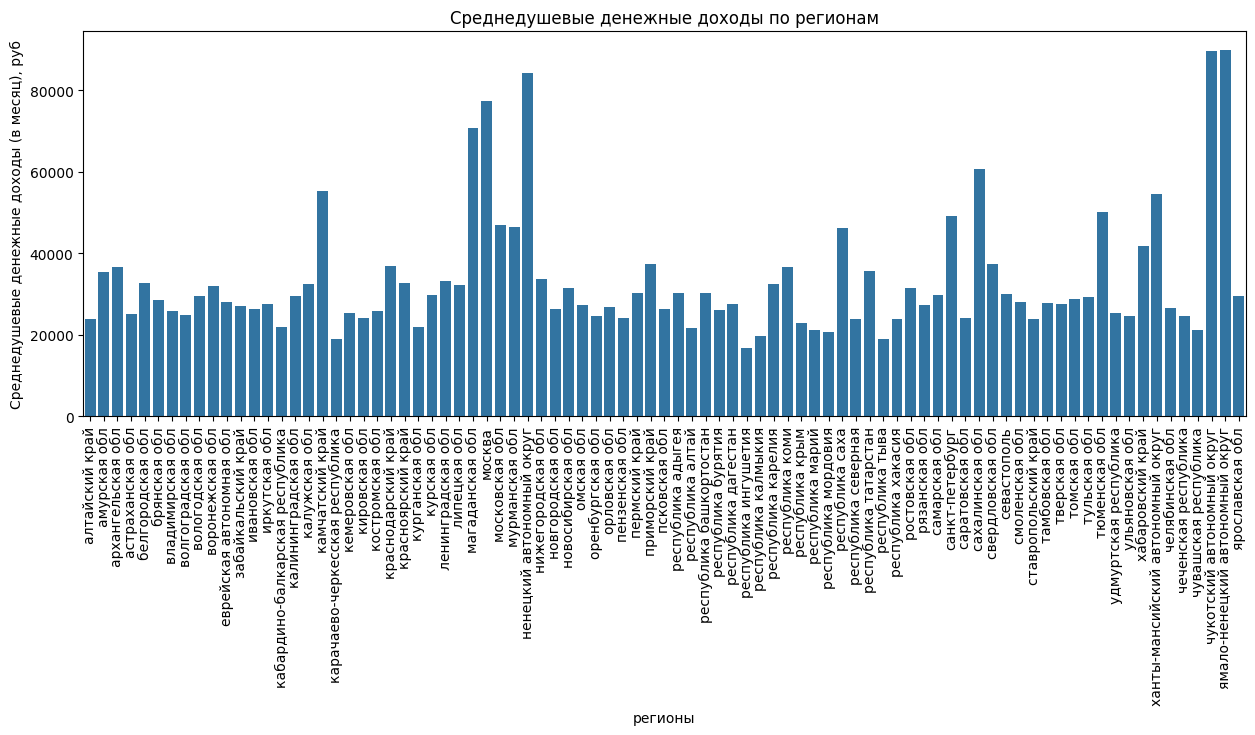

In [1280]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = 'per_capita_cash_income'

)
ax.set(xlabel='регионы', ylabel='Среднедушевые денежные доходы (в месяц), руб', title='Среднедушевые денежные доходы по регионам',)
ax.tick_params(axis='x', rotation=90);

In [1288]:
data[data[data.columns[0]] == data[data.columns[0]].min()]

,per_capita_cash_income,per_capita_cash_income_real_incomes,formal_wage_paid,formal_wage_paid_real_pay,child_mortality_rural,child_mortality_urban,total,18_30,31_40,41_50,...,"Сбор, обработка и утилизация отходов; обработка вторичного сырья_other","ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ_other",ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ_other,"ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА_other",ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА_other,"Производство готовых металлических изделий, не включенных в другие группировки_other","Производство прочих транспортных средств, не включенных в другие группировки_other",Промышленное производство (промышленность)_other,retail_turnover_per_capita_other,welfare_expense_share_other
region,,,,,,,,,,,,,,,,,,,,,
республика ингушетия,16877.0,99.7,29648.0,104.3,23.0,23.0,58205.0,6904.666667,7225.333333,12846.833333,...,0.0,826476.4,920378.4,384177.0,2146473.6,0.0,0.0,4277505.4,50713.0,32.5


Среднедушевые денежные доходы распределены крафне неравномерно по регионам. Как регионы с наибольшем среднедушевым доходом можно выделить чукотский, ненецкий и ямало-ненецкий АО. Из крупных регионов первой ожидаемо идет москва.
Минимальный среднедушевой доход можно отметить у республики ингушетия.

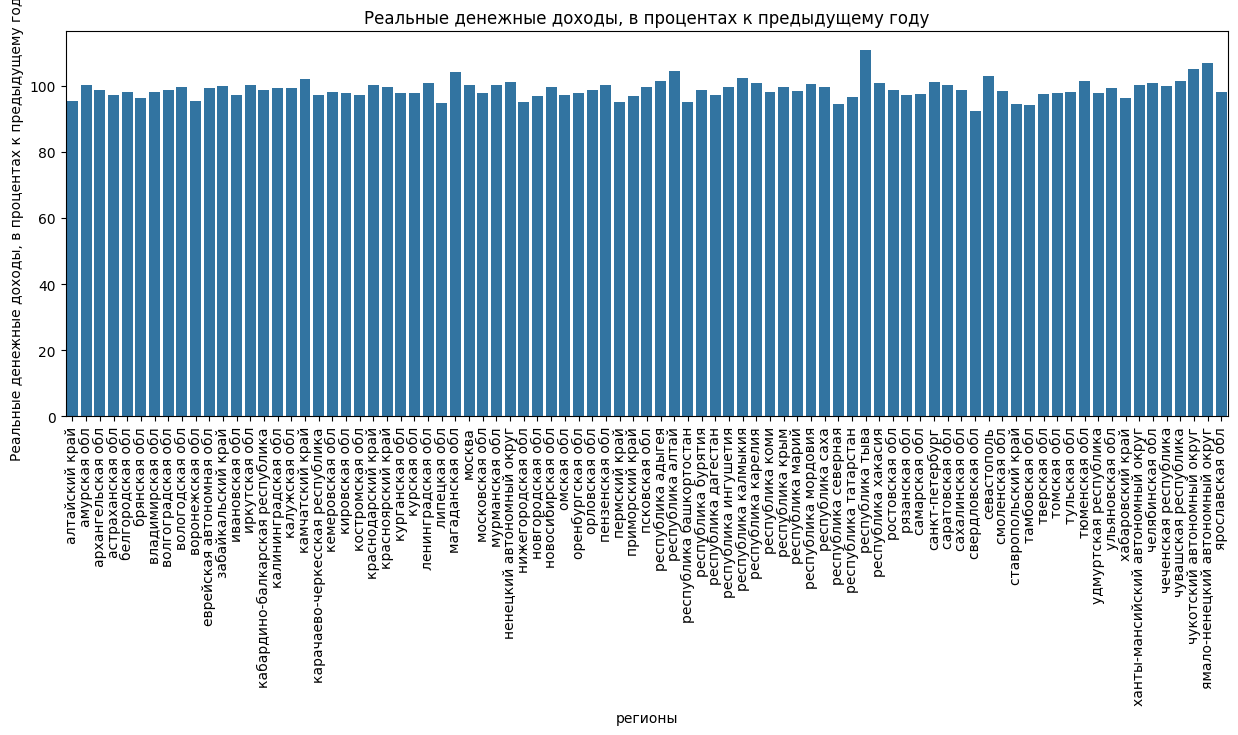

In [1289]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[1]]

)
ax.set(xlabel='регионы', ylabel='Реальные денежные доходы, в процентах к предыдущему году', title='Реальные денежные доходы, в процентах к предыдущему году',)
ax.tick_params(axis='x', rotation=90);